In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta
import pathlib
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
# %load_ext autoreload
# %autoreload 2
import brandear_est as be

In [18]:
SUB_DIR = os.path.join(os.getcwd(), "../../data/submit")
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")

IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")
IMD_RANK_WEEKLY_DIR = os.path.join(IMD_DIR, "rank_weekly")
IMD_ARCHIVE_DIR = os.path.join(IMD_DIR, "arc_rank_weekly")
IMD_VALID_AUCS_DIR = os.path.join(IMD_DIR, "valid_aucs")
IMD_

dset_to_period = {
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

In [5]:
# 元データ読み込み
auction = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "auction.pkl"))
watch = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "watch.pkl"))
bid = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid.pkl"))
bid_success = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid_success.pkl"))
sample_sub = pd.read_csv(os.path.join(os.getcwd(), "../../data/input" , "sample_submission.csv"))
sub_users = sample_sub[["KaiinID"]].drop_duplicates()

In [40]:
def extract_target_actions(watch, bid, period):
    watch_actioned = (
        watch.loc[(watch["TourokuDate"] >= period["oldest"]) & (watch["TourokuDate"] < period["newest"]),
                  ["KaiinID", "AuctionID"]]
    )
    bid_actioned = (
        bid.loc[(bid["ShudouNyuusatsuDate"] >= period["oldest"]) & (bid["ShudouNyuusatsuDate"] < period["newest"]),
                ["KaiinID", "AuctionID"]]
    )
    # 学習用データの際は正解データを作成する
    watch_actioned["watch_actioned"] = 1
    bid_actioned["bid_actioned"] = 1

    target_actions = (
        watch_actioned
        .merge(bid_actioned, on=["KaiinID", "AuctionID"], how="outer")
        .drop_duplicates()
        .fillna(0)
    )

    return target_actions


def build_target_candidate(actions, auction, auc_dataset, period, targets, target_col, dset_type):
        
    target_users = targets[["KaiinID"]].drop_duplicates()

    # 購入履歴から候補作成
    # ユーザーが過去に購入した商品をキーにオークションを紐付ける
    similar_actions = (
        extract_similar_aucs(
            target_users=target_users,
            auction=auction,
            actions=actions,
            period=period
        )
    )
    
    users_auc_cands_cross = None
    
    if dset_type == "submission":
        # 有望オークションと、ユーザーとのクロスジョインから候補作成        
        users_auc_cands_cross = be.cross_join(target_users, auc_dataset)
    else:
        # 正解紐づけ        
        similar_actions = similar_actions.merge(target_actions, on=["AuctionID", "KaiinID"], how="left").fillna(0)
                
        # 有望オークションと、ユーザーとのクロスジョインから候補作成
        # 正解フラグ付与のジョインにかかる時間を短くするために、正解データになる可能性のあるオークションとそうでないオークションで処理を分ける
        auc_dataset_with_ans = auc_dataset.merge(target_actions[["AuctionID", target_col]], on="AuctionID",
                                                 how="left").fillna(0)
        # 正解データになる可能性のあるオークション
        auc_posi_dataset = auc_dataset_with_ans.query(f"{target_col} == 1").drop(target_col, axis=1)
        # 正解データになる可能性のないオークション
        auc_nega_dataset = auc_dataset_with_ans.query(f"{target_col} == 0").drop(target_col, axis=1)

        # クロスジョイン後正解データをジョイン
        auc_posi_dataset_with_ans = (
            be.cross_join(target_users, auc_posi_dataset)
                .merge(target_actions, on=["KaiinID", "AuctionID"], how="left").fillna(0)
        )
        auc_nega_dataset_with_ans = be.cross_join(target_users, auc_nega_dataset)
        auc_nega_dataset_with_ans[target_col] = 0
        # 解データになる可能性のあるオークションとそうでないオークションを結合
        users_auc_cands_cross = pd.concat([auc_posi_dataset_with_ans, auc_nega_dataset_with_ans], sort=False)        
                
    # 購入履歴から作成したペア、有望オークションから作成したペアを結合
    target_candidate = pd.concat([similar_actions, users_auc_cands_cross], sort=False).drop_duplicates()

    return target_candidate


def extract_similar_aucs(target_users, auction, actions, period):
    similar_aucs = (
        actions.merge(target_users, on="KaiinID", how="inner")
            .merge(auction, on="ShouhinID")
    )
    return similar_aucs

In [38]:
def arrange_dtime_condition(watch, bid, auction, period):
    retval = ((
        watch[watch["TourokuDate"] <= period["oldest"]],
        bid[bid["ShudouNyuusatsuDate"] <= period["oldest"]],
        auction[auction["CreateDate"] < period["newest"]]
    ))
    return retval
    

def arrange_inputs(watch, bid, auction, period):
    
    target_actions = extract_target_actions(watch, bid, period)
    
    watch_t, bid_t, auction_t = (
        arrange_dtime_condition(watch=watch, bid=bid, auction=auction, period=period)
    )
    
    arranged_inputs = (
        watch_t.merge(auction_t, on="AuctionID", how="left"),
        bid_t.merge(auction, on="AuctionID", how="left"),
        auction_t,
        target_actions
    )
    return arranged_inputs


In [12]:
watch_vt_dataset = pd.read_pickle(IMD_VALID_AUCS_DIR + "/watch_valid_for_train.pkl")
watch_train_dataset = pd.read_pickle(IMD_VALID_AUCS_DIR + "/watch_train.pkl")

In [47]:
# %%time

auc_attr_col = [
    "AuctionID", "ShouhinID", "SaishuppinKaisuu", "ConditionID", "BrandID",
    "GenreGroupID", "LineID", "SankouKakaku", "CreateDate", "GenreID"
]

target_col = "watch_actioned"

dataset_inputs = {
#     "train": watch_train_dataset,
    "valid_for_train": watch_vt_dataset
#     "valid_for_sub": watch_vs_dataset,
#     "submission": watch_sub_dataset
}

valid_auc_th = 0.3

for dset_type, dataset_input in dataset_inputs.items():
        
    auc_dataset = dataset_input.query(f"pred >= {valid_auc_th}")[auc_attr_col]
    
    watch_arranged, bid_arranged, auction_arranged, target_actions = (
        arrange_inputs(watch=watch, bid=bid, auction=auction, period=dset_to_period[dset_type])
    )
    
    # 特徴量作成
    w_ks_cnts = be.cross_counts(watch_arranged, ["KaiinID", "ShouhinID"])
    w_kb_cnts = be.cross_counts(watch_arranged, ["KaiinID", "BrandID"])
    w_kg_cnts = be.cross_counts(watch_arranged, ["KaiinID", "GenreGroupID"])
    w_kl_cnts = be.cross_counts(watch_arranged, ["KaiinID", "LineID"])
        
    actions = (
        pd.concat([watch_arranged, bid_arranged], sort=False)[["AuctionID", "KaiinID", "ShouhinID"]]
        .drop_duplicates().drop("AuctionID", axis=1)
    )
    
    targets = None
    
    if dset_type != "submission":
        targets = target_actions.sort_values("KaiinID").reset_index(drop=True)[["KaiinID", "AuctionID", target_col]]
    else:
        targets = sub_users
    
    for g, split_targets in targets.groupby(targets["KaiinID"] // 5000):

        
#         import pdb;pdb.set_trace()        
        
        print(dset_type, "分割",g, "番目")        
        if (g > 5) & (dset_type == "train") : continue

        splited_candidates = build_target_candidate(
            actions=actions,
            auction=auction_arranged[auc_attr_col],
            auc_dataset=auc_dataset,
            period=dset_to_period[dset_type],
            targets=split_targets,
            target_col=target_col,
            dset_type=dset_type
        )
        
        splited_candidates_feat = (
            splited_candidates
            .merge(w_ks_cnts, on=["KaiinID", "ShouhinID"], how="left")
            .merge(w_kb_cnts, on=["KaiinID", "BrandID"], how="left")
            .merge(w_kg_cnts, on=["KaiinID", "GenreGroupID"], how="left")
            .merge(w_kl_cnts, on=["KaiinID", "LineID"], how="left")
            .drop(["ShouhinID", "BrandID", "GenreGroupID", "LineID"], axis=1)
            .fillna(0)
        )
        
        be.df2pkl(splited_candidates_feat, IMD_ARCHIVE_DIR + "/"  + dset_type + "/", f"split_cands_{g}.pkl")

valid_for_train 分割 0 番目
valid_for_train 分割 1 番目
valid_for_train 分割 2 番目
valid_for_train 分割 3 番目
valid_for_train 分割 4 番目
valid_for_train 分割 5 番目
valid_for_train 分割 6 番目
valid_for_train 分割 7 番目
valid_for_train 分割 8 番目
valid_for_train 分割 9 番目
valid_for_train 分割 10 番目
valid_for_train 分割 11 番目
valid_for_train 分割 12 番目
valid_for_train 分割 13 番目
valid_for_train 分割 14 番目
valid_for_train 分割 15 番目
valid_for_train 分割 16 番目
valid_for_train 分割 17 番目
valid_for_train 分割 18 番目
valid_for_train 分割 19 番目
valid_for_train 分割 20 番目
valid_for_train 分割 21 番目
valid_for_train 分割 22 番目
valid_for_train 分割 23 番目
valid_for_train 分割 24 番目
valid_for_train 分割 25 番目
valid_for_train 分割 26 番目
valid_for_train 分割 27 番目
valid_for_train 分割 28 番目
valid_for_train 分割 29 番目
valid_for_train 分割 30 番目
valid_for_train 分割 31 番目
valid_for_train 分割 32 番目
valid_for_train 分割 33 番目
valid_for_train 分割 34 番目
valid_for_train 分割 35 番目
valid_for_train 分割 36 番目
valid_for_train 分割 37 番目
valid_for_train 分割 38 番目
valid_for_train 分割 39 番目
valid_for_

In [54]:
%%time
## 予測
dset_pairs = [
    {"old": "train", "new": "valid_for_train"}
]
for dset_pair in dset_pairs:
    paths = (
        sorted([p for p in pathlib.Path(IMD_ARCHIVE_DIR + "/" + dset_pair['old']).iterdir()
               if os.path.basename(p) != ".DS_Store"])[:3]
    )
    drop_cols = ["KaiinID","CreateDate", "AuctoinID"]
    target_col = "watch_actioned"
    datasets = be.DataSet.gen_from_pkls(paths=paths, drop_cols=drop_cols, target_col=target_col)

    undersampled_datasets = [
        {"train_dataset": splited[0], "valid_dataset": splited[1]}
        for splited in 
        [be.DataSet.train_test_split(be.DataSet.under_sampling(d, rate=100))
        for d in datasets]
    ]
    
    models = be.DataEmsembler(be.LgbBinaryClassifier)
    models.train(undersampled_datasets)
    
    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + "/" + dset_pair["new"]).iterdir()):
        if os.path.basename(path) == ".DS_Store": continue        
        print(i)
        tmp = pd.read_pickle(path).fillna(0)
        sub_dataset = be.DataSet(data=tmp, drop_cols=drop_cols, target_col=target_col)
        pred = models.predict(sub_dataset)
        sub_dataset.set_pred(pred)
        
#         print("auc : ", roc_auc_score(sub_dataset.get_target(), sub_dataset.data.pred))        
        
        be.df2pkl(sub_dataset.data, IMD_ARCHIVE_DIR + f"/{dset_pair['new']}_pred/", os.path.basename(path))
#         os.remove(path)

[1]	valid_0's auc: 0.908343
[2]	valid_0's auc: 0.922515
[3]	valid_0's auc: 0.926718
[4]	valid_0's auc: 0.938512
[5]	valid_0's auc: 0.943972
[6]	valid_0's auc: 0.94692
[7]	valid_0's auc: 0.946826
[8]	valid_0's auc: 0.947226
[9]	valid_0's auc: 0.948344
[10]	valid_0's auc: 0.947986
[11]	valid_0's auc: 0.947817
[12]	valid_0's auc: 0.953517
[13]	valid_0's auc: 0.952476
[14]	valid_0's auc: 0.9522
[15]	valid_0's auc: 0.954157
[16]	valid_0's auc: 0.953645
[17]	valid_0's auc: 0.953565
[18]	valid_0's auc: 0.954656
[19]	valid_0's auc: 0.955765
[20]	valid_0's auc: 0.955363
[21]	valid_0's auc: 0.955421
[22]	valid_0's auc: 0.955297
[23]	valid_0's auc: 0.95417
[24]	valid_0's auc: 0.954095
[25]	valid_0's auc: 0.954193
[26]	valid_0's auc: 0.954112
[27]	valid_0's auc: 0.953906
[28]	valid_0's auc: 0.95242
[29]	valid_0's auc: 0.952606
[30]	valid_0's auc: 0.95282
[31]	valid_0's auc: 0.952692
[32]	valid_0's auc: 0.952776
[33]	valid_0's auc: 0.953541
[34]	valid_0's auc: 0.952963
[35]	valid_0's auc: 0.953049


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
CPU times: user 2h 53min 40s, sys: 3min 33s, total: 2h 57min 14s
Wall time: 27min 55s


In [57]:
%%time
## 予測値上位の候補を出力
target_col = "watch_actioned"
th = 1600
dset_types = ["valid_for_train"]
for dset_type in dset_types:
    choiced_cands_buf = []    
    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + f"/{dset_type}_feature_pred/").iterdir()):
        if os.path.basename(path) == ".DS_Store": continue
        splited_action_cands = (
            pd.read_pickle(path)
            .sort_values(['KaiinID', 'pred'], ascending=[True, False])
        )
        splited_action_cands['rank'] = splited_action_cands.groupby('KaiinID')['pred'].cumcount()        
        choiced_cands = splited_action_cands.query(f"rank <= {th}")
        choiced_cands_buf.append(choiced_cands)

    be.df2pkl(pd.concat(choiced_cands_buf), IMD_RANK_WEEKLY_DIR, f"watch_{dset_type}_{th}.pkl")

CPU times: user 1min 40s, sys: 1min 11s, total: 2min 51s
Wall time: 2min 53s


In [12]:
# フィルターをかける前のデータにどのくらいの正解データがあるか
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    target_actions_cnt = 0
    target_actions_pair = (
        extract_target_actions(watch, bid, dset_to_period[dset_type])[["AuctionID", "KaiinID"]].drop_duplicates()
    )
    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + f"/watch_{dset_type}_feature_pred/").iterdir()):
        if os.path.basename(path) == ".DS_Store": continue
        splited_action_cands = pd.read_pickle(path)
        target_actions_cnt += splited_action_cands[["AuctionID", "KaiinID"]].merge(target_actions_pair, on=["AuctionID", "KaiinID"]).shape[0]
    print(dset_type)
    print(target_actions_pair.shape[0])
    print(target_actions_cnt)

valid_for_sub
91044
44055


In [19]:
## フィルターをかけた後にどのくらいの正解データがあるか
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    choiced = pd.read_pickle(IMD_RANK_WEEKLY_DIR +  f"/watch_{dset_type}.pkl")[["AuctionID", "KaiinID"]]
    target_actions_pair = (
        extract_target_actions(watch, bid, dset_to_period[dset_type])[["AuctionID", "KaiinID"]].drop_duplicates()
    )
    print(dset_type)
    print(target_actions_pair.shape[0])
    print(choiced.merge(target_actions_pair, on=["AuctionID", "KaiinID"]).shape[0])

valid_for_sub
91044
15846


In [32]:
## 商品紐付けのみでどのくらいの正解データがあるか
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    target_actions_pair = (
        extract_target_actions(watch, bid, dset_to_period[dset_type])[["AuctionID", "KaiinID"]].drop_duplicates()
    )
    watch_arranged, bid_arranged, auction_arranged, target_actions = (
        arrange_inputs(watch=watch, bid=bid, auction=auction, period=dset_to_period[dset_type])
    )
    similar_aucs = extract_similar_aucs(
        target_users=target_actions_pair[["KaiinID"]].drop_duplicates(), auction=auction,
        actions=pd.concat([watch_arranged, bid_arranged])[["KaiinID", "ShouhinID"]].drop_duplicates(), period=dset_to_period[dset_type]
    )

    print(dset_type)
    print(similar_aucs.shape[0])
    print(target_actions_pair.shape[0])
    print(similar_aucs.merge(target_actions_pair, on=["AuctionID", "KaiinID"]).shape[0])

/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


valid_for_sub
3445777
91044
6731


watch
auc :  0.8984988936359313


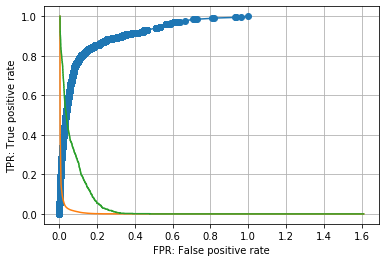

In [299]:
# 推定の精度
tmp = pd.read_pickle(path)
sub_dataset = be.DataSet(data=tmp, drop_cols=drop_cols, target_col=target_col)

target = "watch"
dataset = sub_dataset
print(target)
print("auc : ", roc_auc_score(dataset.get_target(), dataset.data.pred))
be.plot_roc_curve(dataset.get_target(), dataset.data.pred)
be.plot_tpr_fpr(dataset.get_target(), dataset.data.pred)